## Stone Laying

In [852]:
# Inputs: 
#     - List of Stone objects (width, height)
#     - Area dimension

# Output:
#     - List of Stone objects, whether its rotated, and its corresponding location

from random import randint, choice

from copy import deepcopy

X_DIM = 43
Y_DIM = 56
GRID_DIM = (X_DIM-1, Y_DIM-1)

class Stone():
    count = 0
    def __init__(self, width=0, height=0):
        self.width = width
        self.height = height
        self.rotated = False
        self.id = Stone.count
        Stone.count += 1
    
    def __repr__(self):
        return f"(Stone {self.id}, size: {self.width}x{self.height}, rotated: {self.rotated})"
    
    def area(self):
        return self.width * self.height
        
    def rotate(self):
        self.width, self.height = self.height, self.width
        self.rotated = not self.rotated
        
class Grid():
    def __init__(self, storage=[], dim=GRID_DIM, current={}):
        self.dim = dim
        self.current = current
        self.storage = storage
    
    def reset(self):
        self.current = {}
        
    def area(self):
        return (self.dim[0] + 1) * (self.dim[1] + 1)
    
    def covered(self):
        return sum([stone.area() for stone in self.current.keys()])
    
    def uncovered(self):
        return self.area() - self.covered()
    
    def print_all(self):
        if self.current:
            for stone in self.current.keys():
                self.print_stone_info(stone.id)
        else:
            print("Empty Grid")
    
    def invalid(self, stone_id, x, y):
        stone = self.get_stone(stone_id)
        if x < 0 or x > X_DIM - stone.width or y < 0 or y > Y_DIM - stone.height:
            return True
        for stone, loc in self.current.items():
            x_min, x_max = loc[0], loc[0] + stone.width - 1
            y_min, y_max = loc[1], loc[1] + stone.height - 1
            if (x_min <= x <= x_max) and (y_min <= y <= y_max):
                return True
        return False
    
    def empty(self, x, y):
        if x < 0 or x >= X_DIM or y < 0 or y >= Y_DIM:
            return False
        for stone, loc in self.current.items():
            x_min, x_max = loc[0], loc[0] + stone.width - 1
            y_min, y_max = loc[1], loc[1] + stone.height - 1
            if (x_min <= x <= x_max) and (y_min <= y <= y_max):
                return False
        return True
    
    def largest_hole(self):
        max_area = 0
        for x, y in self.top_left_corners():
            x_temp, y_temp = x, y
            while self.empty(x_temp, y):
                x_temp += 1
            while self.empty(x, y_temp):
                y_temp += 1
            max_area = max((x_temp-x)*(y_temp-y), max_area)
        return max_area
    
    def border_coords(self, stone_id):
        stone = self.get_stone(stone_id)
        coords = []
        coords.extend( [(x, 0) for x in range(X_DIM-stone.width+1) if not self.invalid(stone_id, x, 0)] )
        coords.extend( [(x, Y_DIM-stone.height) for x in range(X_DIM-stone.width+1) if not self.invalid(stone_id, x, Y_DIM-stone.height)] )
        coords.extend( [(0, y) for y in range(1, Y_DIM-stone.height) if not self.invalid(stone_id, 0, y)] )
        coords.extend( [(X_DIM-stone.width, y) for y in range(1, Y_DIM-stone.height) if not self.invalid(stone_id, X_DIM-stone.width, y)] )
        return coords
    
    def packer_coords(self, stone_id):
        stone = self.get_stone(stone_id)
        coords = [[], []]
        for y in range(Y_DIM):
            for x in range(X_DIM):
                if not self.invalid(stone_id, x, y):
                    if self.invalid(stone_id, x-1, y) and \
                       self.invalid(stone_id, x, y-1):
                        coords[0].append((x, y))
                    if self.invalid(stone_id, x-1, y) or \
                       self.invalid(stone_id, x, y-1):
                        coords[1].append((x, y))
        return coords
    
    def top_left_corners(self):
        coords = []
        stone_id = -1
        for y in range(Y_DIM):
            for x in range(X_DIM):
                if not self.invalid(stone_id, x, y):
                    if self.invalid(stone_id, x-1, y) and \
                       self.invalid(stone_id, x, y-1):
                        coords.append((x, y))
                    
        return coords
    
    def rotate_stone(self, stone_id):
        self.storage[stone_id].rotate()
    
    def get_stone(self, stone_id):
        if stone_id == -1:
            return Stone(1, 1)
        else:
            return self.storage[stone_id]
    
    def print_stone_info(self, stone_id):
        stone = self.get_stone(stone_id)
        if stone in self.current:
            loc_info = f", loc: {self.current[stone]}"
        else:
            loc_info = ", loc: in storage"
        print(repr(stone) + loc_info)
    
    def place(self, stone_id, loc):
        stone = self.storage[stone_id]
        if self.overlap(stone_id, loc):
#             print("ERROR: STONE OVERLAP")
#             self.print_stone_info(stone_id)
            return False
        elif self.out_of_bounds(stone_id, loc):
#             print("ERROR: STONE OUT OF BOUNDS")
#             self.print_stone_info(stone_id)
            return False
        else:
            self.current[stone] = loc
            return True
        
    def overlap(self, other_id, oloc):
        other = self.get_stone(other_id)
        ox_min, ox_max = oloc[0], oloc[0] + other.width - 1
        oy_min, oy_max = oloc[1], oloc[1] + other.height - 1
        for stone, loc in self.current.items():
            x_min, x_max = loc[0], loc[0] + stone.width - 1
            y_min, y_max = loc[1], loc[1] + stone.height - 1
            if ((ox_min <= x_min <= ox_max) or (x_min <= ox_min <= x_max)) and \
               ((oy_min <= y_min <= oy_max) or (y_min <= oy_min <= y_max)):
                return True
        return False
            
    def out_of_bounds(self, stone_id, loc):
        stone = self.storage[stone_id]
        x_min, x_max = loc[0], loc[0] + stone.width - 1
        y_min, y_max = loc[1], loc[1] + stone.height - 1
        oob_x = x_min < 0 or x_max > self.dim[0]
        oob_y = y_min < 0 or y_max > self.dim[1]
        return oob_x or oob_y

                
        

In [803]:
def sort_stones(stones):
    return sorted(stones, key=lambda s: s.area(), reverse=True)

In [848]:
# stones = sort_stones([Stone(24, 24),
#                      Stone(9, 18),
#                      Stone(18, 18),
#                      Stone(18, 18),
#                      Stone(19, 19),
#                      Stone(18, 9),
#                      Stone(17, 10),
#                      Stone(12, 11)])

# stones = sort_stones([Stone(8, 8),
#                     Stone(9, 1),
#                     Stone(1, 8)])

stones = sort_stones([Stone(24, 24),
                     Stone(9, 18),
                     Stone(18, 18),
                     Stone(18, 18),
                     Stone(19, 19),
                     Stone(18, 9),
                     Stone(11, 9),
                     Stone(13, 9),
                     Stone(12, 11)])

i = 0
for stone in stones:
    stone.id = i
    i += 1
stones

[(Stone 0, size: 24x24, rotated: False),
 (Stone 1, size: 19x19, rotated: False),
 (Stone 2, size: 18x18, rotated: False),
 (Stone 3, size: 18x18, rotated: False),
 (Stone 4, size: 9x18, rotated: False),
 (Stone 5, size: 18x9, rotated: False),
 (Stone 6, size: 12x11, rotated: False),
 (Stone 7, size: 13x9, rotated: False),
 (Stone 8, size: 11x9, rotated: False)]

In [775]:
stones1 = sort_stones([Stone(2, 2),
                      Stone(2, 2),
                      Stone(2, 2),
                      Stone(2, 2),
                      Stone(2, 2),
                      Stone(2, 2),
                      Stone(2, 2),
                      Stone(2, 2),
                      Stone(2, 2),
                      Stone(2, 2),
                      Stone(2, 3),
                      Stone(2, 3),
                      Stone(2, 3),
                      Stone(2, 3),
                      Stone(2, 3),
                      Stone(2, 3),
                      Stone(2, 3),
                      Stone(2, 3),
                      Stone(2, 3),
                      Stone(2, 3)])

i = 0
for stone in stones1:
    stone.id = i
    i += 1
stones1

[(Stone 0, size: 2x3, rotated: False),
 (Stone 1, size: 2x3, rotated: False),
 (Stone 2, size: 2x3, rotated: False),
 (Stone 3, size: 2x3, rotated: False),
 (Stone 4, size: 2x3, rotated: False),
 (Stone 5, size: 2x3, rotated: False),
 (Stone 6, size: 2x3, rotated: False),
 (Stone 7, size: 2x3, rotated: False),
 (Stone 8, size: 2x3, rotated: False),
 (Stone 9, size: 2x3, rotated: False),
 (Stone 10, size: 2x2, rotated: False),
 (Stone 11, size: 2x2, rotated: False),
 (Stone 12, size: 2x2, rotated: False),
 (Stone 13, size: 2x2, rotated: False),
 (Stone 14, size: 2x2, rotated: False),
 (Stone 15, size: 2x2, rotated: False),
 (Stone 16, size: 2x2, rotated: False),
 (Stone 17, size: 2x2, rotated: False),
 (Stone 18, size: 2x2, rotated: False),
 (Stone 19, size: 2x2, rotated: False)]

In [831]:
# TESTING FUNCTIONS
test_grid = Grid(stones1)
test_grid.reset()
test_grid.place(1, (0, 0))
test_grid.place(10, (0, 3))
test_grid.print_all()

# Test placing 3x2 stone
test_coords = []
# for y in range(-1, Y_DIM):
#     for x in range(-1, X_DIM):
#         if not test_grid.invalid(0, x, y):
#             test_coords.append((x, y))

test_grid.top_left_corners()
test_grid.largest_hole()


(Stone 1, size: 2x3, rotated: False), loc: (0, 0)
(Stone 10, size: 2x2, rotated: False), loc: (0, 3)


80

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

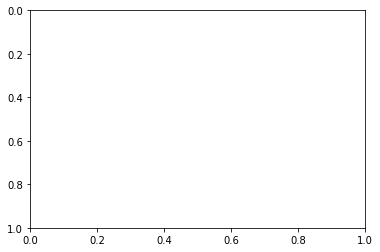

In [821]:
# Coordinate plotter
plt.gca().invert_yaxis()
plt.scatter(*zip(*test_coords))

# Randomized Strategy

In [642]:
# RANDOM STRATEGY

# NUM_EPOCHS = 1000
# NUM_TRIES = 1000

# grid = Grid(stones1)
# tries = 0
# stone_id = 0
# max_score = 0
# epoch = 0
# best = {}

# grid.reset()
# while epoch < NUM_EPOCHS:
#     while stone_id < len(grid.storage)-1 and tries < NUM_TRIES:
#         if tries == NUM_TRIES:
#             stone_id += 1
#             tries = 0
#         if randint(0, 1):
#             grid.rotate_stone(stone_id)
#         rand_x = randint(0, grid.dim[0]+grid.get_stone(stone_id).width)
#         rand_y = randint(0, grid.dim[1]+grid.get_stone(stone_id).height)
#         if not grid.place(stone_id, (rand_x, rand_y)):
#             tries += 1
#         else:
#             stone_id += 1
#             tries = 0
#     curr_score = grid.covered()
#     if curr_score > max_score:
#         best = deepcopy(grid.current)
#         max_score = curr_score
#     tries = 0
#     stone_id = 0
#     epoch += 1
#     grid.reset()
    
# best

{(Stone 0, size: 3x2, rotated: False): (7, 0),
 (Stone 1, size: 3x2, rotated: False): (7, 8),
 (Stone 2, size: 3x2, rotated: False): (5, 6),
 (Stone 3, size: 2x3, rotated: True): (8, 3),
 (Stone 4, size: 3x2, rotated: False): (3, 0),
 (Stone 5, size: 2x3, rotated: True): (2, 2),
 (Stone 6, size: 2x3, rotated: True): (1, 7),
 (Stone 7, size: 2x3, rotated: True): (3, 7),
 (Stone 8, size: 2x3, rotated: True): (0, 0),
 (Stone 9, size: 3x2, rotated: False): (2, 5),
 (Stone 10, size: 2x2, rotated: True): (5, 8),
 (Stone 11, size: 2x2, rotated: True): (6, 2),
 (Stone 12, size: 2x2, rotated: False): (6, 4),
 (Stone 13, size: 2x2, rotated: True): (0, 5),
 (Stone 14, size: 2x2, rotated: True): (4, 3),
 (Stone 15, size: 2x2, rotated: False): (8, 6),
 (Stone 16, size: 2x2, rotated: True): (0, 3)}

# Border Hugger

In [693]:
# BORDER HUGGER STRATEGY

# NUM_EPOCHS = 1000
# NUM_TRIES = 100

# grid = Grid(stones1)
# tries = 0
# stone_id = 0
# max_score = 0
# epoch = 0
# best = {}

# grid.reset()
# while epoch < NUM_EPOCHS:
#     while stone_id < len(grid.storage)-1 and tries < NUM_TRIES:
#         # Enough tries?
#         if tries == NUM_TRIES:
#             stone_id += 1
#             tries = 0
            
#         # Rotate stone?
#         if randint(0, 1):
#             grid.rotate_stone(stone_id)
            
#         # Border coordinates?
#         borders = grid.border_coords(stone_id)
#         if borders:
#             try_loc = choice(borders)
#         else:
#             stone_id += 1
#             tries = 0
            
#         # Try placing the stone
#         if not grid.place(stone_id, try_loc):
#             tries += 1
#         else:
#             stone_id += 1
#             tries = 0
#     curr_score = grid.covered()
#     if curr_score > max_score:
#         best = deepcopy(grid.current)
#         max_score = curr_score
#     tries = 0
#     stone_id = 0
#     epoch += 1
#     grid.reset()
    
# best

{(Stone 0, size: 2x3, rotated: True): (6, 7),
 (Stone 1, size: 3x2, rotated: False): (2, 8),
 (Stone 2, size: 2x3, rotated: True): (8, 5),
 (Stone 3, size: 2x3, rotated: True): (8, 0),
 (Stone 4, size: 3x2, rotated: False): (0, 4),
 (Stone 5, size: 2x3, rotated: True): (4, 0),
 (Stone 6, size: 2x3, rotated: True): (0, 0),
 (Stone 7, size: 2x3, rotated: True): (6, 0),
 (Stone 8, size: 2x3, rotated: True): (2, 0),
 (Stone 9, size: 3x2, rotated: False): (0, 6),
 (Stone 10, size: 2x2, rotated: False): (8, 8),
 (Stone 11, size: 2x2, rotated: False): (8, 3),
 (Stone 12, size: 2x2, rotated: False): (0, 8)}

# Packing Strategy

In [855]:
NUM_EPOCHS = 5000
NUM_TRIES = 50
NUM_BATCHES = 10
BATCH_SIZE = NUM_EPOCHS // NUM_BATCHES

grid = Grid(stones)
tries = 0
stone_id = 0
max_score = 0
low_hole_score = X_DIM * Y_DIM
epoch = 0
best = {}

grid.reset()
while epoch < NUM_EPOCHS:
    while stone_id < len(grid.storage) and tries < NUM_TRIES:
        # Enough tries?
        if tries == NUM_TRIES:
            stone_id += 1
            tries = 0
            
        # Rotate stone?
#         if randint(0, 1):
#             grid.rotate_stone(stone_id)
            
        # Border coordinates?
        packers = grid.packer_coords(stone_id)
        if packers[0]:
            try_loc = choice(packers[0])
            grid.place(stone_id, try_loc)
            last_used = stone_id
            stone_id += 1
        elif packers[1]:
            try_loc = choice(packers[1])
            grid.place(stone_id, try_loc)
            last_used = stone_id
            stone_id += 1
        else:
            stone_id += 1
            
        # Try placing the stone
#         if not grid.place(stone_id, try_loc):
#             tries += 1
#         else:
#             stone_id += 1
#             tries = 0

    curr_score = grid.covered()
    if curr_score >= max_score and grid.largest_hole() < low_hole_score:
        best = deepcopy(grid.current)
        max_score = curr_score
        low_hole_score = grid.largest_hole()
    if epoch % BATCH_SIZE == 0:
        print(f"Batch {epoch // BATCH_SIZE} out of {NUM_BATCHES}") 
    tries = 0
    stone_id = 0
    epoch += 1
    grid.reset()
    
best

Batch 0 out of 10
Batch 1 out of 10
Batch 2 out of 10
Batch 3 out of 10
Batch 4 out of 10
Batch 5 out of 10
Batch 6 out of 10
Batch 7 out of 10
Batch 8 out of 10
Batch 9 out of 10


{(Stone 0, size: 24x24, rotated: False): (0, 0),
 (Stone 1, size: 19x19, rotated: False): (24, 0),
 (Stone 2, size: 18x18, rotated: False): (0, 24),
 (Stone 3, size: 18x18, rotated: False): (18, 24),
 (Stone 5, size: 18x9, rotated: False): (0, 42),
 (Stone 6, size: 12x11, rotated: False): (18, 42),
 (Stone 7, size: 13x9, rotated: False): (30, 42)}

In [599]:
# def stone_layer(grid, tries, stone_id=0, max_score=0, epoch=0, best={}):
#     if stone_id >= len(grid.storage) or tries > 100:
#         if grid.covered() > max_score:
#             maxed_score = grid.covered()
#             best = grid.current.copy()
#             grid.reset()
#             return stone_layer(grid, 0, 0, maxed_score, epoch+1, best)
#         else:
#             grid.reset()
#             return stone_layer(grid, 0, 0, max_score, epoch+1, best)

#     if epoch > 50:
#         return grid.current
#     rand_x = randint(0, grid.dim[0])
#     rand_y = randint(0, grid.dim[1])
    
#     if grid.place(stone_id, (rand_x, rand_y)):
#         return stone_layer(grid, 0, stone_id+1, max_score, epoch)
#     else:
#         return stone_layer(grid, tries+1, stone_id, max_score, epoch)

In [837]:
analysis_grid = Grid()
analysis_grid.current = best


[]

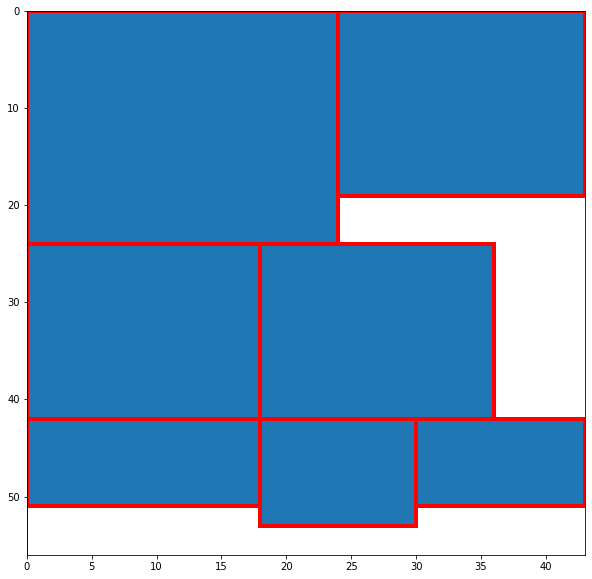

In [857]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.axis([0, GRID_DIM[0]+1, 0, GRID_DIM[1]+1])
plt.gca().add_patch(plt.Rectangle((0, 0), GRID_DIM[0]+1, GRID_DIM[1]+1, ec='r', fc='w'))
plt.gca().invert_yaxis()
for stone, coord in best.items():
    plt.gca().add_patch(plt.Rectangle(coord, stone.width, stone.height, ec='r', lw=4))
    
plt.plot()

(0.0, 2.0, 0.0, 14.0)

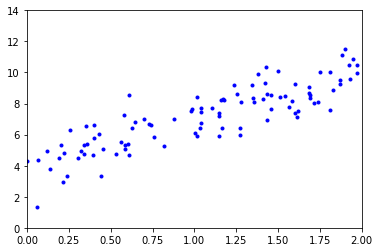

In [138]:
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 14])

In [139]:
X.shape, y.shape

((100, 1), (100, 1))

In [140]:
X_b = np.c_[np.ones((100, 1)), X]
X_b.shape

(100, 2)

In [141]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.98836397],
       [3.02333529]])

In [142]:
X_new = np.array([[0], [2]])
X_new.shape

(2, 1)

In [143]:
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.98836397],
       [10.03503455]])

(0.0, 2.0, 0.0, 15.0)

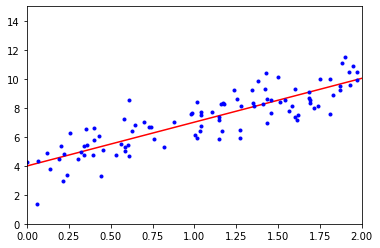

In [144]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])

In [145]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.98836397]), array([[3.02333529]]))

In [146]:
lin_reg.predict(X_new)

array([[ 3.98836397],
       [10.03503455]])

# Normal Equation: 

$$\hat\theta = (X^T X)^{-1} X^T y$$

# Pseudoinverse (Moore-Penrose Inverse):

$$\hat{\theta}  =  X^+  y$$

$$X^+  =  V {\Sigma}^+ U^T$$

$\Sigma^+$ takes $\Sigma$, sets to zero all values smaller than a tiny threshold value, replaces all nonzero values with their inverse, and transposes that matrix.

In [147]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.98836397],
       [3.02333529]])

In [148]:
# This is the pseudo inverse of X_b
np.linalg.pinv(X_b).dot(y)

array([[3.98836397],
       [3.02333529]])

In [56]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)
theta

array([[1.53361736],
       [1.90241356]])

In [59]:
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
theta

array([[3.97012611],
       [3.1285218 ]])

In [94]:
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, 'b.')
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = 'b-' if iteration > 0 else 'r--'
            a = (10 - iteration) / 10
            plt.plot(X_new, y_predict, style, alpha=a)
        gradients = gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
    plt.axis([0, 2, -15, 15])

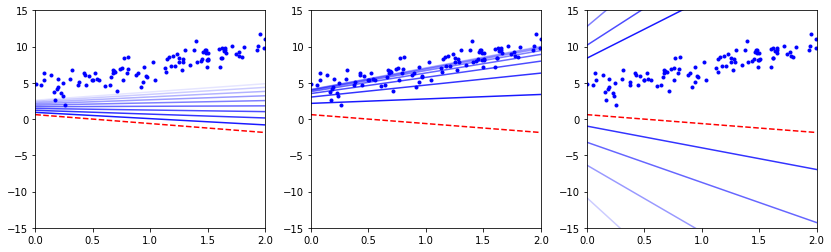

In [95]:
theta = np.random.randn(2, 1)

plt.figure(figsize=(14, 4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

# Stochastic Gradient Descent

In [102]:
X_b.shape, y.shape, X_new_b.shape

((100, 2), (100, 1), (2, 2))

In [123]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)
theta

array([[0.46450052],
       [0.93366379]])

(0.0, 2.0, 0.0, 15.0)

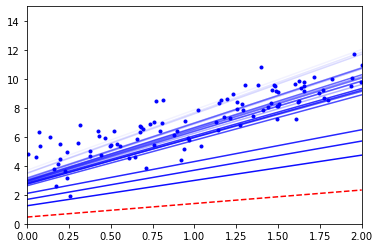

In [124]:
for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = 'b-' if i > 0 else 'r--'
            a = (20 - i) / 20
            plt.plot(X_new, y_predict, style, alpha=a)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])


In [127]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [128]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.00612666]), array([3.15419831]))

# Mini-batch Gradient Descent

In [152]:
n_iterations = 50
minibatch_size = 20

theta = np.random.randn(2, 1)

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        
theta

array([[4.07238059],
       [3.14700619]])

# Polynomial Regression

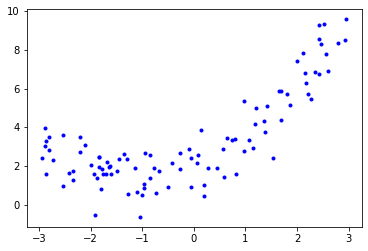

In [216]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, 'b.')

In [217]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-2.10717086]), array([-2.10717086,  4.44016902]))

In [218]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.97215055]), array([[1.06175824, 0.49192452]]))

In [219]:
X_poly_b = np.c_[np.ones((m, 1)), X_poly]

In [220]:
theta = np.random.randn(3, 1)
theta

array([[ 1.27256969],
       [ 0.86233394],
       [-1.20195478]])

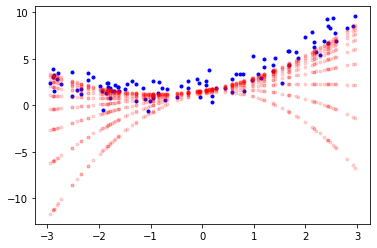

In [242]:
eta = 0.01
n_iterations = 1000

def plot_gradient_descent2(theta, eta):
    m = len(X_poly_b)
    plt.plot(X, y, 'b.')
    i = 0
    for iteration in range(n_iterations):
        if iteration < 10:
            y_pred = X_poly_b.dot(theta)
            plt.plot(X, y_pred, 'r.', alpha=0.15)
        gradients = gradients = 2/m * X_poly_b.T.dot(X_poly_b.dot(theta) - y)
        theta = theta - eta * gradients
        
plot_gradient_descent2(theta, eta)

array([[1.97203142],
       [1.06175754],
       [0.4919473 ]])

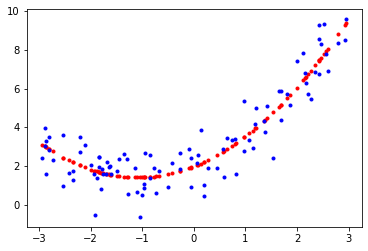

In [243]:
y_pred = X_poly_b.dot(pred_theta)
plt.plot(X, y_pred, 'r.')
plt.plot(X, y, 'b.')
pred_theta

# Learning Curves

In [246]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)

In [290]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))
    plt.figure(figsize=(10, 4))
    plt.axis([0, 80, 0, 4])
    plt.plot(np.sqrt(train_errors), label='train')
    plt.plot(np.sqrt(val_errors), label='val')
    plt.legend()
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    


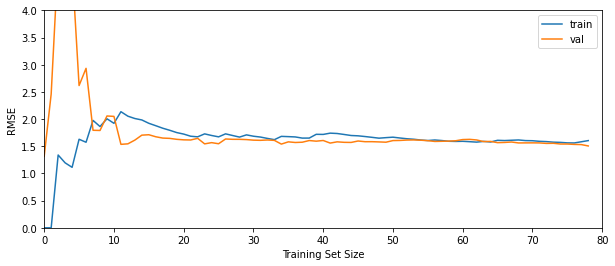

In [294]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

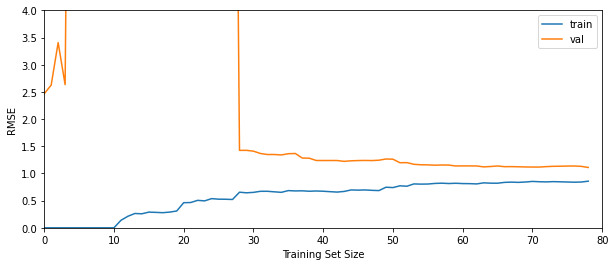

In [295]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

# Ridge Regression

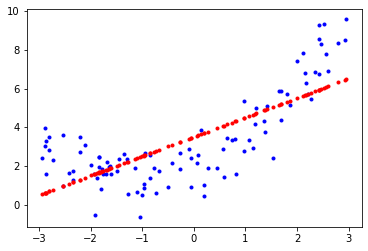

In [303]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
y_pred_ridge = ridge_reg.predict(X)
plt.plot(X, y, 'b.')
plt.plot(X, y_pred_ridge, 'r.')

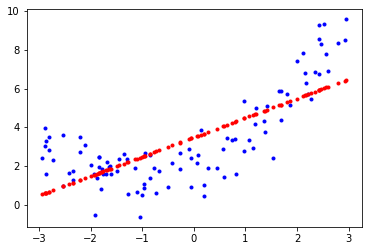

In [306]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
y_pred_sgd_ridge = sgd_reg.predict(X)
plt.plot(X, y, 'b.')
plt.plot(X, y_pred_sgd_ridge, 'r.')

In [312]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

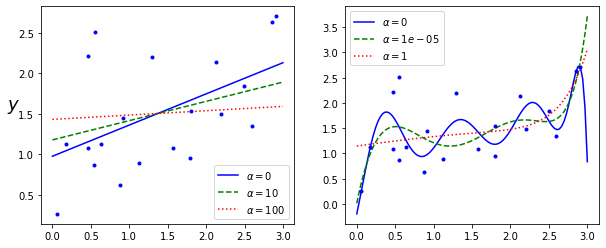

In [316]:
from sklearn.preprocessing import StandardScaler

def plot_model(model_class, alphas, polynomial, **model_kargs):
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('regul_reg', model)
            ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, 'b.')    
    plt.legend()
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
            

/Users/nitinnazeer/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827423, tolerance: 0.0009294783355207351
  model = cd_fast.enet_coordinate_descent(


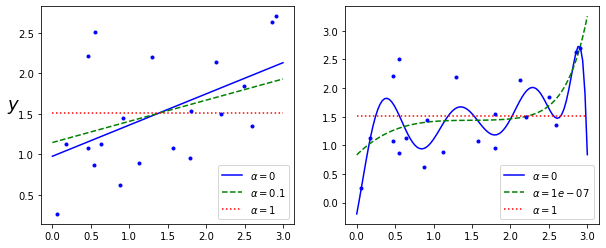

In [317]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(10,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

In [318]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

In [319]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

# Early Stopping

In [862]:
import numpy as np
from sklearn.model_selection import train_test_split

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [869]:
for data in X_train, X_val, y_train, y_val:
    print("Type: ", type(data), " shape: ", data.shape)

Type:  <class 'numpy.ndarray'>  shape:  (25, 1)
Type:  <class 'numpy.ndarray'>  shape:  (25, 1)
Type:  <class 'numpy.ndarray'>  shape:  (25,)
Type:  <class 'numpy.ndarray'>  shape:  (25,)


In [875]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

poly_scaler = Pipeline([
            ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
            ("std_scaler", StandardScaler())
                      ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

In [881]:
def print_info(*args):
    """
    Utility function to print type and shape of data structures.
    
    INPUT: One or more data structures
    OUTPUT: Type and shape of each data structure   
    """
    for data in args:
        print(f"Type: {type(data)}, Shape: {data.shape}")

In [882]:
print_info(X_train_poly_scaled, X_val_poly_scaled)

Type: <class 'numpy.ndarray'>, Shape: (25, 90)
Type: <class 'numpy.ndarray'>, Shape: (25, 90)


In [922]:
from sklearn.linear_model import SGDRegressor
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from copy import deepcopy

num_epochs = 5000

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
train_errors, val_errors = [], []
for epoch in range(num_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    train_error = mean_squared_error(y_train, y_train_predict)
    val_error = mean_squared_error(y_val, y_val_predict)
    train_errors.append(train_error)
    val_errors.append(val_error)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)
        
      

In [923]:
best_epoch

2252

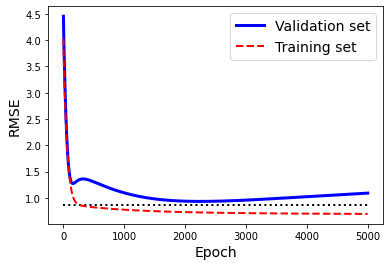

In [924]:
plt.plot([0, num_epochs], [minimum_val_error, minimum_val_error], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

# Logistic Regression

In [1064]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [1065]:
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [1066]:
X = iris["data"][:, 3:]
X.shape

(150, 1)

In [1067]:
y = (iris["target"] == 2).astype(int)

In [1068]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

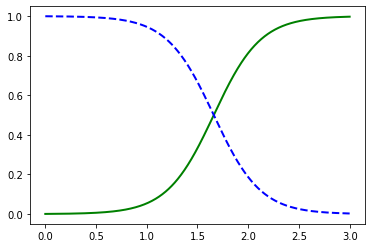

In [1081]:
X_plot = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_plot)

plt.plot(X_plot, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_plot, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

### Manual Logistic Regression with L2 penalty (one feature w/ bias)

In [1101]:
# Manual Logistic Regression

X_b = np.c_[np.ones(len(X)), X]
y_b = y.reshape(-1, 1)
theta = np.random.randn(2, 1)
eta = 1
n_iter = 100
C = 10 ** 10
m = len(X_bias)

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

In [1102]:
for iteration in range(n_iter):
    gradients = 1/C * theta + (1/m) * X_b.T @ (sigmoid(X_b @ theta) - y_b)
    theta = theta - (eta * gradients)

In [1103]:
theta.shape

(2, 1)

In [1104]:
X_plot_b = np.c_[np.ones(len(X_plot)), X_plot]
y_plot_b = sigmoid(X_plot_b @ theta)

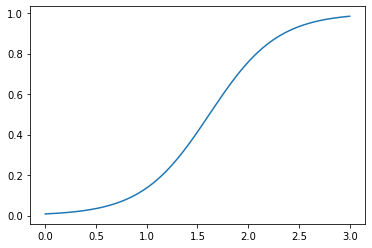

In [1105]:
plt.plot(X_plot, y_plot_b)

### Manual Logistic Regression with L2 penalty (two features w/ bias)

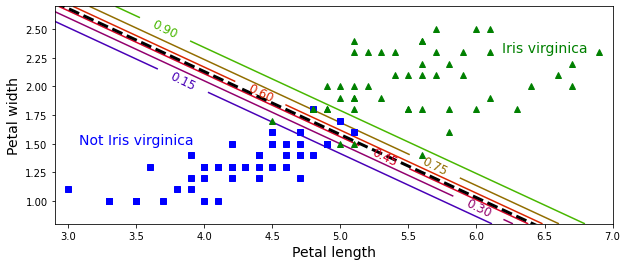

In [1108]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

# Softmax Regression (Multinomial Logistic Regression)

In [1117]:
X = iris["data"][:, (2, 3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [1119]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )

X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_pred = softmax_reg.predict(X_new)

(0.0, 7.0, 0.0, 3.5)

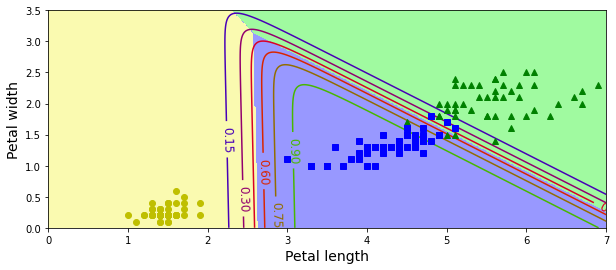

In [1124]:
zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_pred.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([0, 7, 0, 3.5])

# Question 7: Implement Batch Gradient Descent w/ Early Stopping for Softmax Regression

In [1182]:
X = iris["data"][:, (2, 3)]
y = iris["target"]

In [1183]:
X_b = np.c_[np.ones((len(X), 1)), X]

In [1184]:
np.random.seed(2042)

In [1185]:
test_ratio = 0.2
val_ratio = 0.2
total_size = len(X_b)

test_size = int(test_ratio * total_size)
val_size = int(val_ratio * total_size)
train_size = total_size - test_size - val_size

rnd_indices = np.random.permutation(total_size)

X_train = X_b[rnd_indices[:train_size]]
X_val = X_b[rnd_indices[train_size:-test_size]]
X_test = X_b[rnd_indices[-test_size:]]
y_train = y[rnd_indices[:train_size]]
y_val = y[rnd_indices[train_size:-test_size]]
y_test = y[rnd_indices[-test_size:]]




In [1186]:
print_info(X_train, X_val, X_test, y_train, y_val, y_test)

Type: <class 'numpy.ndarray'>, Shape: (90, 3)
Type: <class 'numpy.ndarray'>, Shape: (30, 3)
Type: <class 'numpy.ndarray'>, Shape: (30, 3)
Type: <class 'numpy.ndarray'>, Shape: (90,)
Type: <class 'numpy.ndarray'>, Shape: (30,)
Type: <class 'numpy.ndarray'>, Shape: (30,)


In [1187]:
def one_hot(y):
    """
    Return a one-hot vectorized 2D array with:
    - m rows, representing m samples
    - n columns, representing n possible classes
    
    Each row will have a certain class selected using the number 1.
    """
    num_classes = y.max() + 1
    num_samples = len(y)
    y_one_hot = np.zeros((num_samples, num_classes))
    y_one_hot[np.arange(num_samples), y] = 1
    return y_one_hot

In [1188]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [1189]:
one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [1190]:
Y_train_one_hot = one_hot(y_train)
Y_val_one_hot = one_hot(y_val)
Y_test_one_hot = one_hot(y_test)

In [1191]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

In [1192]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

In [1193]:
n_inputs, n_outputs

(3, 3)

In [1194]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

In [1195]:
for iteration in range(n_iterations):
    logits = X_train @ Theta # m by 3
    Y_proba = softmax(logits) # m by 3
    Y_error = Y_proba - Y_train_one_hot # m by 3
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    gradients = (1 / m) * X_train.T @ Y_error
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693314
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.4729228972192248
3500 0.44824244188957774
4000 0.42786510939287936
4500 0.41060071429187134
5000 0.3956780375390373


In [1196]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

In [1197]:
logits = X_val.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_val)
accuracy_score

0.9666666666666667

In [1199]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_val.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_val_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109128
1500 0.5355752782580262
2000 0.5331959249285545
2500 0.5325946767399382
2765 0.5325460966791898
2766 0.5325460971327978 early stopping!


In [1202]:
logits = X_val.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_val)
accuracy_score

1.0

(0.0, 7.0, 0.0, 3.5)

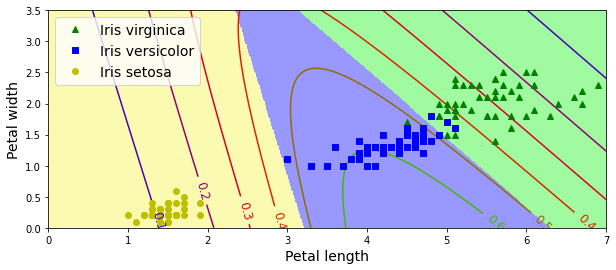

In [1203]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])